<a href="https://colab.research.google.com/github/Alishba18001778/Codes/blob/main/AE_WeatherClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Load useful packages
!pip install wget
from random import sample

import keras
# import os.path
from os import path
import h5py
import keras.backend as K
import numpy as np
import tensorflow as tf
import wget
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras.models import Model
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, losses

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9675 sha256=1c699ef5eae9d36ed1fc8adfd3c6f8c0f257847ceb804d3fba301d4c7d678598
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
classes = ('cloudy','rain','shine','sunrise')
data_path = 'https://raw.githubusercontent.com/Shujaat123/Weather_Classification/master/dataset/'

flist = []
for fname in classes:
  filename = 'WeatherClassificationDB_'+fname+'.mat'
  if(path.exists(filename)):
    !rm $filename
    print('existing file:', filename, ' has been deleted')
  print('downloading latest version of file:', filename)
  file_path = data_path + filename
  wget.download(file_path, filename)
  print('DONE')
  flist.append(filename)

downloading latest version of file: WeatherClassificationDB_cloudy.mat
DONE
downloading latest version of file: WeatherClassificationDB_rain.mat
DONE
downloading latest version of file: WeatherClassificationDB_shine.mat
DONE
downloading latest version of file: WeatherClassificationDB_sunrise.mat
DONE


In [3]:
cloudy_imgs = np.array(h5py.File(flist[0], 'r')['images']['input'])
rain_imgs = np.array(h5py.File(flist[1], 'r')['images']['input'])
shine_imgs = np.array(h5py.File(flist[2], 'r')['images']['input'])
sunrise_imgs = np.array(h5py.File(flist[3], 'r')['images']['input'])

InputImages = np.concatenate((cloudy_imgs,rain_imgs,shine_imgs,sunrise_imgs), axis = 0)
InputImages = InputImages/InputImages.max()

print(cloudy_imgs.shape)
print(rain_imgs.shape)
print(shine_imgs.shape)
print(sunrise_imgs.shape)
print(InputImages.shape)

(207, 256, 256, 3)
(215, 256, 256, 3)
(253, 256, 256, 3)
(357, 256, 256, 3)
(1032, 256, 256, 3)


In [4]:
num_CL_Tr = np.round(len(cloudy_imgs)*0.7246).__int__()
num_RA_Tr = np.round(len(rain_imgs)*0.697).__int__()
num_SH_Tr = np.round(len(shine_imgs)*0.592).__int__()
num_SUN_Tr = np.round(len(sunrise_imgs)*0.420).__int__()
print(num_CL_Tr)
print(num_RA_Tr)
print(num_SH_Tr)
print(num_SUN_Tr)
CL_list = list(range(0,len(cloudy_imgs)))
RA_list = list(range(0,len(rain_imgs)))
SH_list = list(range(0,len(shine_imgs)))
SUN_list = list(range(0,len(sunrise_imgs)))
CL_Train = sample(CL_list,num_CL_Tr)
RA_Train = sample(RA_list,num_RA_Tr)
SH_Train = sample(SH_list,num_SH_Tr)
SUN_Train = sample(SUN_list,num_SUN_Tr)


train_list = CL_Train + RA_Train + SH_Train + SUN_Train

num_CL_Te = len(cloudy_imgs) - num_CL_Tr
num_RA_Te = len(rain_imgs) - num_RA_Tr
num_SH_Te = len(shine_imgs) - num_SH_Tr
num_SUN_Te = len(sunrise_imgs) - num_SUN_Tr
print(num_CL_Te)
print(num_RA_Te)
print(num_SH_Te)
print(num_SUN_Te)

CL_Test = sample(set(CL_list) - set(CL_Train), num_CL_Te)
RA_Test = sample(set(RA_list) - set(RA_Train), num_RA_Te)
SH_Test = sample(set(SH_list) - set(SH_Train), num_SH_Te)
SUN_Test = sample(set(SUN_list) - set(SUN_Train), num_SUN_Te)

test_list = CL_Test + RA_Test + SH_Test + SUN_Test


150
150
150
150
57
65
103
207


In [5]:
Input_train = np.concatenate((cloudy_imgs[CL_Train],rain_imgs[RA_Train],shine_imgs[SH_Train],sunrise_imgs[SUN_Train]), axis = 0)
print(Input_train.shape)
Input_test = np.concatenate((cloudy_imgs[CL_Test],rain_imgs[RA_Test],shine_imgs[SH_Test],sunrise_imgs[SUN_Test]), axis = 0)
print(Input_test.shape)

(600, 256, 256, 3)
(432, 256, 256, 3)


In [8]:
Input_train, Input_test = Input_train / 255.0, Input_test / 255.0

In [9]:
def my_model():
  input_img = Input(shape=(256,256,3))
  num_filter = 256
  kernel_size = 3
  strides = 1   
  
  x = Conv2D(num_filter, kernel_size, strides, activation='relu', padding='same', name = 'enc1')(input_img)

  x = Conv2D(3, kernel_size, strides, activation='relu', padding='same', name = 'enc2')(x) 
  x = AveragePooling2D((2, 2))(x)

  x = Conv2D(3, kernel_size, strides, activation='relu', padding='same', name = 'enc4')(x) 
  x = AveragePooling2D((2, 2))(x)   

  encoded = BatchNormalization()(x)
  

  x = UpSampling2D((2,2), interpolation = 'bilinear')(encoded)
  x = Conv2DTranspose(3, kernel_size, strides, activation='relu', padding='same', name = 'dec1')(x)

  x = UpSampling2D((2,2), interpolation = 'bilinear')(x)        
  x = Conv2DTranspose(3, kernel_size, strides, activation='relu', padding='same', name = 'dec2')(x) 
  x = BatchNormalization()(x)
  
  x = Conv2DTranspose(num_filter, kernel_size, strides, activation='relu', padding='same', name = 'dec4')(x)
  x = BatchNormalization()(x) 
  decoded = Conv2D(3,(1, 1), activation='relu', name = 'output')(x)

  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
  return autoencoder

autoencoder = my_model()


In [10]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
enc1 (Conv2D)                (None, 256, 256, 256)     7168      
_________________________________________________________________
enc2 (Conv2D)                (None, 256, 256, 3)       6915      
_________________________________________________________________
average_pooling2d_2 (Average (None, 128, 128, 3)       0         
_________________________________________________________________
enc4 (Conv2D)                (None, 128, 128, 3)       84        
_________________________________________________________________
average_pooling2d_3 (Average (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 3)         12  

In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

checkpoint = ModelCheckpoint('models\\modelweather-best.h5',
                                  verbose=0, monitor='val_loss',save_best_only=True, mode='auto')

autoencoder.fit(Input_train, Input_train,
                epochs=200,
                batch_size=32,
                shuffle=True,
                validation_data=(Input_test, Input_test),
                callbacks = [es, checkpoint]
                )

del autoencoder  # deletes the existing model
autoencoder = load_model('models\\modelweather-best.h5')

Epoch 1/200
19/19 [==============================] - 36s 2s/step - loss: 18494.7290 - val_loss: 17281.2363
Epoch 2/200
19/19 [==============================] - 23s 1s/step - loss: 16544.5822 - val_loss: 16704.9531
Epoch 3/200
19/19 [==============================] - 23s 1s/step - loss: 15741.4018 - val_loss: 16294.8809
Epoch 4/200
19/19 [==============================] - 24s 1s/step - loss: 14251.9240 - val_loss: 15858.2979
Epoch 5/200
19/19 [==============================] - 24s 1s/step - loss: 13561.8246 - val_loss: 15115.0693
Epoch 6/200
19/19 [==============================] - 24s 1s/step - loss: 12183.1462 - val_loss: 14229.2432
Epoch 7/200
19/19 [==============================] - 24s 1s/step - loss: 10616.3877 - val_loss: 13330.2871
Epoch 8/200
19/19 [==============================] - 24s 1s/step - loss: 10119.5146 - val_loss: 12464.5322
Epoch 9/200
19/19 [==============================] - 24s 1s/step - loss: 9063.9818 - val_loss: 11433.2422
Epoch 10/200
19/19 [==================

In [12]:
predicted_test = autoencoder.predict(Input_test[:100])
predicted_test = np.clip(predicted_test, 0., 1.)
print(predicted_test[1].shape)

(256, 256, 3)


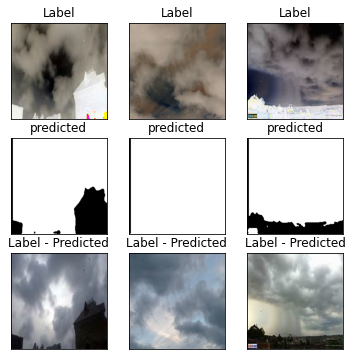

In [13]:
n = 3
plt.figure(figsize=(6, 6))
for i in range(n):

    # display original + noise
    ax = plt.subplot(3, n, i + 1)
    plt.title("Label")
    plt.imshow(tf.squeeze((Input_test[i]*255).astype('uint8')))
 #   plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(3, n, i + n + 1)
    plt.title("predicted")
    plt.imshow(tf.squeeze((predicted_test[i]*255).astype('uint8')))
 #   plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 2*n + 1)
    plt.title("Label - Predicted")
    residual = np.squeeze(np.abs(Input_test[i] - predicted_test[i]))
    residual = residual/residual.max()
    plt.imshow((residual*255).astype('uint8')) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
print(cloudy_imgs.shape) # (NHWC)
print(cloudy_labels.shape)

print(rain_imgs.shape) # (NHWC)
print(rain_labels.shape)

print(shine_imgs.shape) # (NHWC)
print(shine_labels.shape)

print(sunrise_imgs.shape) # (NHWC)
print(sunrise_labels.shape)


InputImages = np.concatenate((cloudy_imgs,rain_imgs,shine_imgs,sunrise_imgs), axis = 0)
InputImages = InputImages/InputImages.max()